# **Gradient-Boosted Machine (GBM) Supervised Classification for Predicting Patient Disease from Hospital Data**
___
### A Project By **Shaan Sidhwani**
___

## **Project Discription:**

This project uses the multi-class **Gradient-Boosted Machine (GBM) supervised classification** model to diagnostically predict a patient’s medical condition by using a combination of demographic, behavioral, and physiological health indicators. Using the "Healthcare Risk Factors" Dataset found on Kaggle, which has nearly 30,000 anonymized patient records, my goal is to **identify which health metrics most strongly predict diabetes, hypertension, asthma, arthritis, cancer, and obesity** in hospital patients prior to their stay. Health metrics provided in the dataset include include **oxygen saturation (%), BMI, cholesterol (mg/dL), and systolic blood pressure (mmHg)** amongst others. This work focuses on building a statistically robust model that can accurately distinguish between these medical condition categories and identify features that carry the greatest predictive power.

To accomplish this, the GBM model uses a **One vs. Rest (OvR)** boosting strategy. After cleaning, normalizing, and encoding the dataset, we select features through **Recursive Feature Elimination (RFE)** and evaluate the model using **stratified $k$-fold** cross-validation ($k$ = 5). Stratification is critical in this case since some diseases, such as cancer, occur less frequently than others, and maintaining the relative frequencies of medical conditions in each fold supports more accurate training. Performance is tested using **ROC curves**, classification indicators (**precision, recall, F1 scores, and accuracy**), and **confusion matrices** to visualize classification patterns.
<br>
<br>
___

## **Library Import Declarations**

In [1]:
# numerical computation and data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning prep-processing, feature selection, and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

# base estimator for recursive feature elimination
from sklearn.tree import DecisionTreeRegressor

# model evaluation metrics
from sklearn.metrics import  confusion_matrix, roc_auc_score, RocCurveDisplay

In [2]:
disease_df = pd.read_csv("chronic_diseases.zip")
disease_df.head(10)

,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426
5,50.0,Male,Hypertension,107.00,171.80,25.33,95.21,5,233.10,203.67,5.48,1,0,5.01,4.65,0,7.25,6.35,ipsum,108.411983
6,80.0,Male,Hypertension,NaN,174.52,29.87,97.96,3,247.11,128.27,5.99,1,1,1.92,5.76,1,8.25,7.23,ipsum,7.009539
7,50.0,Male,Cancer,NaN,136.13,26.37,82.72,19,209.26,137.79,6.23,1,0,5.34,3.34,0,8.76,4.94,###,64.247308
8,60.0,Female,Obesity,NaN,NaN,35.49,98.62,3,264.69,194.21,6.83,0,0,1.66,2.99,0,5.93,5.87,lorem,45.855558
9,13.0,Female,Asthma,90.60,126.88,29.24,97.96,6,193.44,163.65,6.18,1,0,5.27,5.63,0,7.09,5.41,lorem,-45.916696


___
## **Visualizing the Hospital Data**

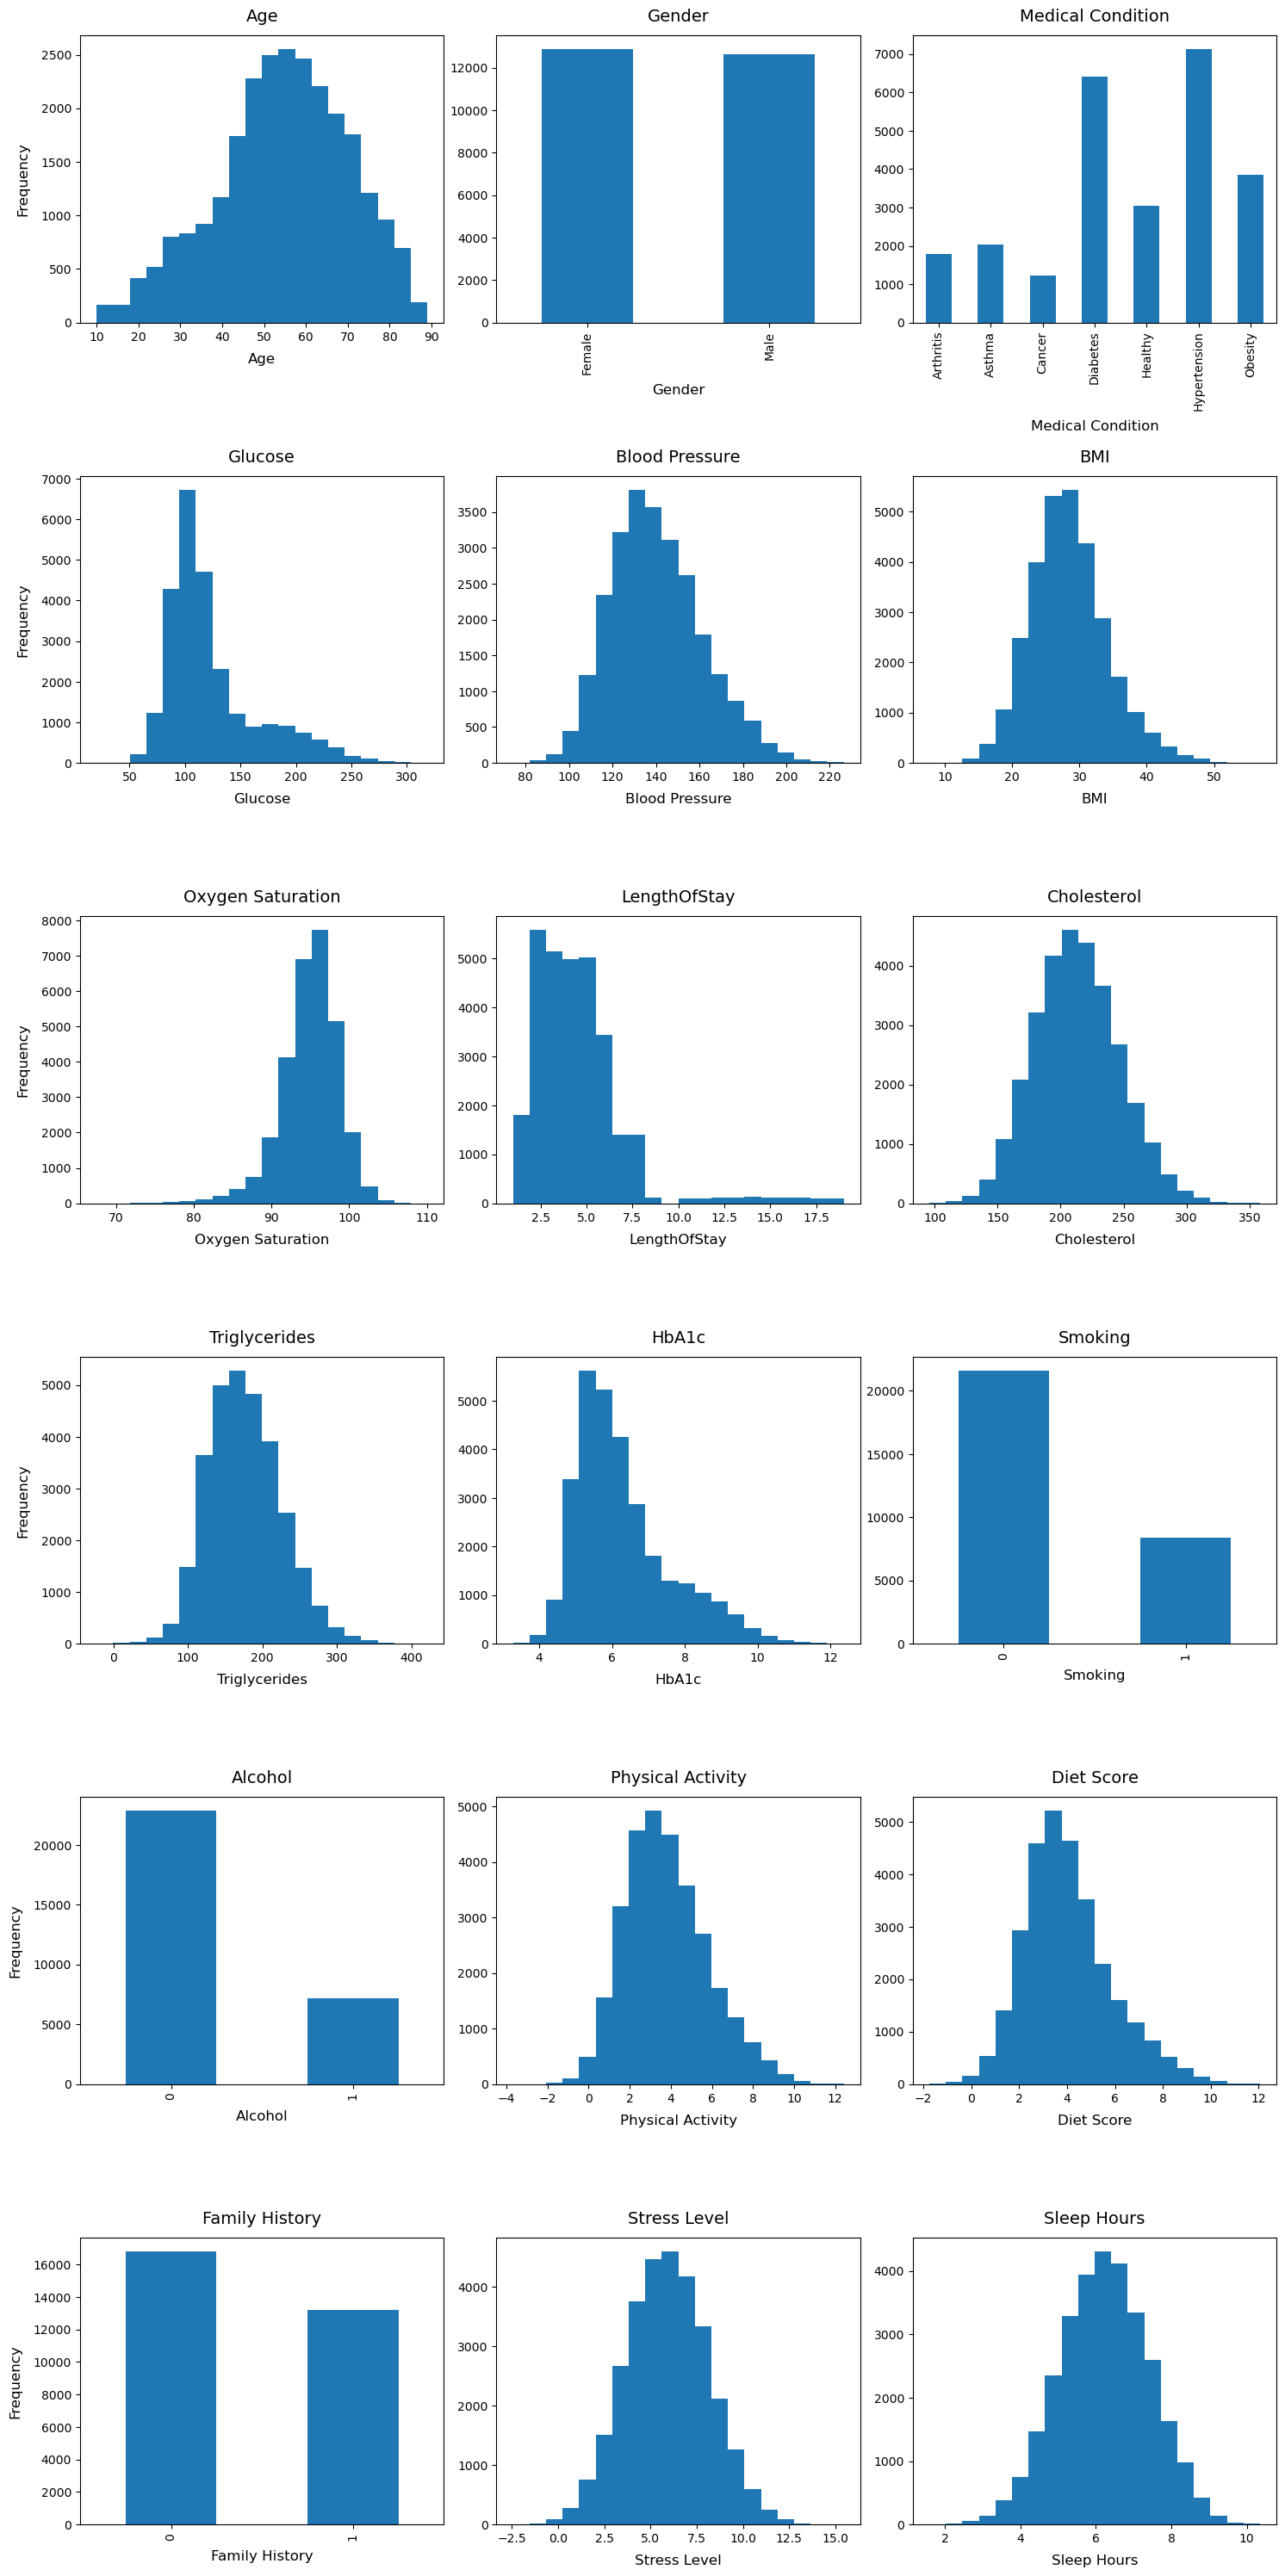

In [3]:
## Plot Parameters
# 6 x 3 subplot grid with adjusted figure and font sizes
N_ROWS_GRID = 6
N_COLS_GRID = 3
FIG_WIDTH = 5 * N_COLS_GRID
FIG_HEIGHT = 5 * N_ROWS_GRID
LABEL_FONTSIZE = 12
TITLE_FONTSIZE = 14

# padding to space labels on each subplot
TITLE_PAD = 12
XLABEL_PAD = 8
YLABEL_PAD = 10

# space between each subplot for tight_layout()
TIGHT_LAYOUT_PAD = 1.0
TIGHT_LAYOUT_W_PAD = 0.5
TIGHT_LAYOUT_H_PAD = 1.3

# remove irrelevant and designate desired columns in plot
noise = ['random_notes', 'noise_col']
cols = [col for col in disease_df.columns if col not in noise]
numeric_cols = disease_df.select_dtypes(include='number').columns

# create subplots
fig, axes = plt.subplots(N_ROWS_GRID, N_COLS_GRID, figsize=(FIG_WIDTH, FIG_HEIGHT))
axes = axes.flatten()

# loop through and plot all columns in df
for subplot_idx, col in enumerate(cols):
    freq = disease_df[col].value_counts(dropna=True).sort_index()
    
    # plot histogram for numeric with >2 unique values, else bar plot
    if col in numeric_cols and len(freq) > 2:
        axes[subplot_idx].hist(disease_df[col].dropna(), bins=20)
    else:
        freq.plot(kind='bar', ax=axes[subplot_idx])

    # show y-axis label for first column of each row; set x-axis labels and titles
    if subplot_idx % N_COLS_GRID == 0:
        axes[subplot_idx].set_ylabel('Frequency', fontsize=LABEL_FONTSIZE, labelpad=YLABEL_PAD)
    axes[subplot_idx].set_xlabel(col, fontsize=LABEL_FONTSIZE, labelpad=XLABEL_PAD)
    axes[subplot_idx].set_title(col, fontsize=TITLE_FONTSIZE, pad=TITLE_PAD)

# adjust subplot spacing and display
plt.tight_layout(pad=TIGHT_LAYOUT_PAD, w_pad=TIGHT_LAYOUT_W_PAD, h_pad=TIGHT_LAYOUT_H_PAD)
plt.show()

## **What Do The Visualizations Tell Us?**

* **Most health metrics follow a normal distribution** with a moderate spread. Some predictors like "Cholesterol", "Triglycerides", and "BMI" do show a right skew, while factors like "Age" and "Blood Pressure" show tight clusters that are true to population averages.
* **Categorical variables (Gender, Family History, Smoking, Alcohol) vary more sharply however**. For example, "Smoking" and "Alcohol" use show a large class imbalance, with non-smokers and non-drinkers forming the large majority of the dataset. Similarly, "Medical Condition", the column we are trying to predict, is not evenly distributed: "Hypertension" and "Diabetes" appear far more frequently than "Cancer" and "Asthma".

#### The above information has ramifications for how the model is trained below.

___
## **Descriptive Patient Statistics**

In [4]:
# select relevant numeric columns and obtain descriptive statistics for each
df_numeric = disease_df.drop(columns=['noise_col']).select_dtypes(include='number')
desc = df_numeric.describe().T

# compute IQR, skewness, kurtosis for each column
desc['IQR'] = desc['75%'] - desc['25%']
desc['Skew'] = df_numeric.apply(pd.Series.skew)
desc['Kurtosis'] = df_numeric.apply(pd.Series.kurtosis)

# round to 2 decimal places and rename columns in statistics df for clarity
desc = desc[['mean', 'std', '25%', '50%', '75%', 'IQR', 'Skew', 'Kurtosis']].round(2)
desc = desc.rename(columns={
    'mean': 'Mean',
    'std': 'StDev',
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3'
    })

# display descriptive statistics df
desc.T

,Age,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours
Mean,54.62,123.62,140.46,28.48,94.95,4.41,213.03,176.84,6.29,0.28,0.24,3.80,4.03,0.44,5.92,6.23
StDev,15.97,41.58,21.08,5.73,3.74,2.76,33.52,48.81,1.32,0.45,0.43,2.01,1.82,0.50,2.23,1.19
Q1,45.00,96.28,125.14,24.59,93.00,3.00,189.50,141.28,5.33,0.00,0.00,2.35,2.77,0.00,4.37,5.41
Median,55.00,110.50,138.32,28.05,95.30,4.00,211.84,173.36,5.97,0.00,0.00,3.59,3.79,0.00,5.90,6.23
Q3,66.00,136.61,153.79,31.81,97.38,5.00,235.31,208.63,6.92,1.00,0.00,5.06,5.02,1.00,7.44,7.05
IQR,21.00,40.33,28.65,7.22,4.38,2.00,45.81,67.35,1.59,1.00,0.00,2.71,2.25,1.00,3.07,1.64
Skew,-0.32,1.35,0.47,0.48,-0.93,2.18,0.20,0.40,1.05,0.98,1.23,0.49,0.65,0.24,0.07,-0.04
Kurtosis,-0.31,1.41,0.08,0.56,2.61,7.35,-0.04,0.29,0.74,-1.04,-0.49,0.05,0.49,-1.94,-0.13,-0.17


## **Quantitative Overview**

The central values of each variable such as the mean age (≈56 years), mean BMI (≈28 kg/m²), and mean systolic blood pressure (≈145 mmHg) fall within clinically plausible ranges for a dataset with chronic diseases. Standard deviations are moderate relative to their means, suggesting few extreme outliers.

However, a few features stand out slightly: "Glucose" and "HbA1c" both show significant right-skew most likely due to diabetic patients with elevated blood sugar. "Triglycerides" also has long-tail behavior, which is expected in a clinical setting. In contrast, "Stress Level" exhibits a symmetric normal distribution. "Sleep Hours" has a relatively smaller standard deviation with respect to the mean, which indicates that patients report sleep durations within a small band. Though these irregularities do not significantly influence data processing and modelling, they help explain why Recursive Feature Elimination (RFE) selected features such as "Glucose", "Blood Pressure", "BMI", and "Oxygen Saturation". These features display meaningful skew and correlate with known disease progression pathways.

___
## **What Patient Information is in the Dataset?**

### The dataset contains the following categorical and numerical parameters for patients staying at a hospital:
* **Age**: Patient’s age (years)

* **Gender**: What sex the patient was assigned at birth (Male = 0, Female = 1)

* **Medical Condition**: Reported health condition ("Arthritis", "Asthma", "Cancer", "Diabetes", "Healthy", "Hypertension", or "Obesity")

* **Glucose**: Blood glucose level (mg/dL)

* **Blood Pressure**: Systolic blood pressure (mmHg)

* **BMI**: Body Mass Index (kg/m²)

* **Oxygen Saturation**: Blood oxygen saturation level (%)

* **LengthOfStay**: Hospital stay duration (number of days)

* **Cholesterol**: Cholesterol level (mg/dL)

* **Triglycerides**: Triglyceride level (mg/dL)

* **HbA1c**: Hemoglobin A1c, or average glucose level over past 2-3 months (%)

* **Smoking**: Smoking status (0 = Non-smoker, 1 = Smoker)

* **Alcohol**: Alcohol consumption (0 = No, 1 = Yes)

* **Physical Activity**: Physical activity (approx. hours/week)

* **Diet Score**: Diet quality score (subjective numeric scale)

* **Family History**: Family History of Disease Occurrence (0 = No, 1 = Yes)

* **Stress Level**: Stress level (subjective numeric scale)

* **Sleep Hours**: Amount of sleep (approx. hours/day)

## **Data Pre-Processing**
##### The data is unclean and requires significant processing to proceed with the ML model. **We observe**:
* **Plenty of NaN values** that must be removed since we are only interested in complete cases.

In [5]:
# remove rows that contain any NaN values; we are interested only in complete cases
removedNaNs_df = disease_df.dropna()

* **Uninformative columns** like "random_notes" and "noise_col" that contain no useful predictors or health information. 
* **Needless column:** "LengthofStay" (hospital stay duration) is removed since the goal is to diagnostically predict disease upon hospital arrival.

In [6]:
# drop uninformative categories and 'LengthofStay' since we want to predict disease prior to hospital admission
clean_df = removedNaNs_df.drop(columns=['random_notes', 'noise_col', 'LengthOfStay'])

* **Metrics that use arbitrary, subjective scales** like "Stress Level" and "Diet Score" that have most values ranging from 0 to 10. Since values are likely computed on a 0-10 scale and values outside this range are very rare, we will filter values outside these thresholds and apply z-score normalization to fit these columns to the standard normal distribution.
* **Impossible/unphysical values** such as some patients having negative concentrations (mg/dL) of "Triglycerides", negative approximate hours of "Physical Activity", and "Oxygen Saturation" values greater than 100%.

In [7]:
# make stress levels and diet scores conform to 0-10 scale using lambda function
clean_df = clean_df[
    clean_df[['Stress Level','Diet Score']].apply(lambda s: s.between(0, 10)).all(axis=1)]

# remove rows with physically unreasonable, impossible values
clean_df = clean_df[(clean_df['Physical Activity'] >= 0) & 
                    (clean_df['Triglycerides'] >= 0) & 
                    (clean_df['Oxygen Saturation'] <= 100)]

* **Numeric columns require normalization** according to z-scores in the standard normal distribution to assist with implementing gradient descent, L2 normalization, and in providing numerical stability for features with large or tiny ranges.

In [8]:
# z-score normalization of continuous numeric columns according to standard normal distribtuon (0 mean, 1 std dev)
exclude_cols = ['Smoking', 'Alcohol', 'Family History']
norm_cols = clean_df.select_dtypes(include='number').columns
norm_cols = [col for col in norm_cols if col not in exclude_cols]

scaler = StandardScaler()
clean_df[norm_cols] = scaler.fit_transform(clean_df[norm_cols])

* **Categorical variables require encoding/conversion to integers** for appropriate handling by the machine learning model. For example, "Male" is mapped to 0 and "Female" is mapped to 1 in the "Gender" column.
    * Since the **"Medical Condition"** column contains the **labels** we want the model to train to predict, its original string values are stored in a mapping dictionary for the inteprretation of model outputs.

In [9]:
# map 'Gender' column from 'Male' --> 0, 'Female' --> 1 respectively
clean_df['Gender'] = clean_df['Gender'].map({'Male': 0, 'Female': 1})

# map medical conditions to integers and extract mapping for later use
# 'Arthritis' = 0, 'Asthma' = 1, 'Cancer' = 2, 'Diabetes' = 3, Healthy' = 4, 'Hyptertension' = 5, and 'Obesity' = 6
clean_df['Medical Condition'] = clean_df['Medical Condition'].astype('category')
cats = clean_df['Medical Condition'].cat.categories # ordered list of category labels
idx_to_condition = {i: label for i, label in enumerate(cats)} # dictionary mapping

# implement conversion to integer codes
clean_df['Medical Condition'] = clean_df['Medical Condition'].cat.codes
clean_df['Medical Condition'] = clean_df['Medical Condition'].astype('category').cat.codes

#### **Why not use the One-Hot Encoding (OHE) Method?**
* The GBM model can naturally handle **integer-encoded labels** with decision trees splitting on the thresholds of these integers for multi-class classification.
* OHE contributes **excess dimensionality** that could slow down training when applied to predictors.
* The GBM **model is insensitive** to scale and ordering of input parameters
* The method **impedes interpretability** compared to using a mapping dictionary.
<br>
#### **Cleaned & Normalized DataFrame**

In [10]:
# reset indices to preserve clean, sequential indexing
clean_df = clean_df.reset_index(drop=True)

print(f"We have removed {disease_df.shape[0] - clean_df.shape[0]:,} rows with invalid values!\n"
      + f"The cleaned dataset now has {clean_df.shape[0]:,} rows:")
clean_df.head(10)

We have removed 18,093 rows with invalid values!
The cleaned dataset now has 11,907 rows:


,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours
0,-2.048352,0,4,-1.245799,-1.275516,-0.373838,0.869784,-1.399508,-0.981710,-1.044185,0,0,2.130950,1.033563,0,0.052308,1.236187
1,0.716830,1,5,-0.683105,1.807783,0.463650,0.109641,1.383553,-1.262845,-0.240197,0,1,-0.160600,-0.365730,0,0.303671,0.328999
2,-0.288690,0,5,-0.400206,1.505154,-0.540295,0.198900,0.600706,0.557894,-0.615892,1,0,0.568072,0.333916,0,0.732468,0.085403
3,-2.613957,1,1,-0.791729,-0.628926,0.137671,0.990716,-0.574009,-0.271826,-0.089918,1,0,0.698731,0.882439,0,0.653609,-0.704187
4,-1.419901,0,4,-0.223305,-0.813734,-0.611386,0.342867,-1.750797,-0.853998,-1.149380,1,0,0.522845,1.397379,1,-1.165080,1.462984
5,0.339760,0,5,-0.751144,-0.561464,-0.193509,0.512747,-0.430946,-0.252752,-1.502534,1,0,1.457556,-0.617603,1,0.412103,0.832993
6,1.219591,0,5,-0.453205,-0.705415,0.129002,1.413978,-0.836142,0.381045,-1.472478,1,1,0.547971,0.065252,0,0.969045,0.186201
7,-0.602916,0,3,1.935082,-0.225104,0.212230,-1.623716,-0.548832,-1.695535,1.803587,1,1,0.050463,-0.824698,1,0.072023,-0.183394
8,0.591140,1,3,3.691919,0.523154,0.874591,0.365901,0.284368,-0.582608,1.037168,0,1,-1.396832,-0.365730,0,0.865542,-0.258993
9,1.470971,0,5,-0.120888,-1.050801,0.689061,1.022389,0.658761,2.047118,-1.081755,1,0,-0.899324,0.776093,1,1.220408,-0.737786


___
## **Decision Tree Regressor Class**
DecisionTree acts like a **wrapper class** around Scikit-Learn's DecisionTreeRegressor base estimator.
The class provides a minimal interface with residual error fitting and prediction methods. The trees
are intentionally kept shallow since they are meant to individually be **weak learners**.

In [11]:
class DecisionTree:
    """
    This is a wrapper class around a DecisionTreeRegressor object for
    use in gradient boosting that provides a minimal interface with
    residual error fitting and prediction methods.
    """

    def __init__(self, max_depth=3):
        """
        Initialize an object instance of the DecisionTree class using
        Scikit-Learn's DecisionTreeRegressor as the base estimator.

        Parameters
        ----------
        max_depth : int, default = 3
            The maximum depth, or the number of splits/decisions, 
            that can occur in the decision tree. The trees are intentionally
            kept shallow.
        """
        self.tree = DecisionTreeRegressor(max_depth=max_depth)

    def fit(self, X, residuals):
        """
        Fit the decision tree (decide nodal splits) according to model residuals,
        or the differences between true and predicted target values, using the
        Mean Squared Error (MSE) loss function.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Feature input matrix used for fitting the tree.
        residuals : array-like
            The target values (residuals) for training the tree.
        """
        self.tree.fit(X, residuals)

    def predict(self, X):
        """
        Compute and predict target outputs from the given input feature matrix by
        traversing the fitted decision tree for each row in the input.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Feature input matrix that is traversed to generate predictions.

        Returns
        -------
        predictions : numpy.ndarray
            Predicted residual values from the fitted decision tree.
        """
        return self.tree.predict(X)

___
## **How Does the GBMClassifier Class Work?**

The **GBMClassifier** implements a multi-class gradient boosting model using the **One-vs-Rest (OvR)** approach, fitting multiple weak learners (decision trees) sequentially to minimize the multi-class log-loss.

### **Notation & Definitions**

* The **sample index**, $i \in \{1,\dots,n\}$, is an integer that identifies a single row, or patient, in the input data where $n$ is the total number of patients.
* The **class index**, $k \in \{1,\dots,K\}$, is an integer that identifies a possible target label, or medical condition. $K$ is the total number of distinct medical conditions in the dataset. This dataset has 7 total medical conditions.
* $d$ is the **number of health input features/predictors** per sample, or patient.
* $x_i \in \mathbb{R}^d$ is the **predictor/input data vector** containing health information for patient $i$. It is written as a length-$d$ row vector.
* $y_{i,k} \in \{0,1\}$ is the **one-hot true label indicator**. It equals 1 if sample $i$ truly belongs to class $k$, else it is 0.
    * **Note**: Though we do NOT use One-Hot Encoding, $y_{i,k}$ is still useful in gradient computation.
* $z_{i,k}$ is the **raw score** that quantifies how strongly the model favors a particular $k$ class (medical condition) for patient $i$.
* $f_{t,k}(x_i)$ is the output of the $t$-th tree for class $k$ that quantifies how much to add to the raw score given a feature vector argument.
* $\eta$ is the **learning rate**, 0 < $\eta$ ≤ 1, that scales base estimator decision tree contributions in the GBM model.

### **Keeping Track of Raw Score**

The **raw score**, $z_{i,k}$, is the unnormalized model output of each of the decision tree base estimators that quantifies how strongly the model favors, or "votes" for, a particular $k$ class (medical condition) for patient $i$. It can be expressed as:

$$z_{i,k} = \eta\sum_{t=1}^T \, f_{t,k}(x_i)$$

The raw score is initialized as $z_{i,k}=0$ for all $i,k$ at the beginning, and the existing score is incremented by $\eta f_{t,k}(x_i)$ after each decision tree is run in the ensemble method.

### **Using Softmax to Convert Raw Scores to Probabilities**

Since $z_{i,k}$ raw scores are unbounded and difficult to compare across classes, we use the **Softmax function** to transform raw scores by mapping them to the $[0,1]$ interval for each class, producing **interpretable probabilities** that can be compared across classes:

$$p_{i,k} = \frac{e^{z_{i,k}}}{\sum_{j=1}^K e^{z_{i,j}}}$$

This fulfills the **axioms of probability**, such as:
$$0 \le p_{i,k} \le 1; \quad \sum_{k=1}^K p_{i,k} = 1$$

Using $e^{z_{i,k}}$ exponentials ensures all probabilities are positive so that no class can have a negative likelihood, and dividing by the sum of exponentials guarantees that the probabilities sum to 1, allowing us to treat them as a proper probability distribution over classes. Softmax is also smooth and differentiable, which is crucial in computing the **gradient of the loss function** with respect to $z_{i,k}$ is used in gradient boosting to fit residuals. This scheme naturally extends binary classification to $K$ classes, making it compatible with **OvR approach** where each class has its own ensemble of trees contributing to $z_{i,k}$. 

### **Loss Function: Multinomial Cross-Entropy (Log Loss)**

The **multinomial cross-entropy**, also called **categorical log loss**, is the loss function for multi-class classification with softmax outputs and therefore the one that is used for this model. It measures the discrepancy between predicted class probabilities $p_{i,k}$ and the true class labels $y_{i,k}$. For a single sample $i$, the loss function is:

$$\ell_i = - \sum_{k=1}^{K} y_{i,k} \, \log p_{i,k}$$

* $y_{i,k} \in \{0,1\}$ is the one-hot indicator for the true class. It evaluates to 1 for the true class and 0 for all other classes. Hence, only the term corresponding to the true class contributes to the sum.
- $p_{i,k}$ is the predicted probability for class $k$. This loss function penalizes predictions that assign low probability to the correct class and rewards assigning higher probabilities.

For all $n$ samples, or patients, the **total loss function** we seek to minimize is:

$$\mathcal{L} = \sum_{i=1}^{n} \ell_i = - \sum_{i=1}^{n} \sum_{k=1}^{K} y_{i,k} \, \log p_{i,k}$$

### **Gradient and Hessian of the Loss Function**

To optimize the GBM model, we compute the **gradient** and **Hessian** of the loss function with respect to the raw scores $z_{i,k}$. These quantities indicate **how wrong the current predictions are** and **how confident the model is** respectively, and are used to fit the base decision trees at each boosting iteration. We re-write the single-sample $i$ loss-function as:

$$\ell_i = - \sum_{k=1}^{K} y_{i,k} \, \log p_{i,k} = - \sum_{k=1}^{K} y_{i,k} \log \frac{e^{z_{i,k}}}{\sum_{j=1}^{K} e^{z_{i,j}}} 
= - \sum_{k=1}^{K} y_{i,k} (z_{i,k} - \log \sum_{j=1}^{K} e^{z_{i,j}}) = - \sum_{k=1}^{K} y_{i,k} z_{i,k} + \log \sum_{j=1}^{K} e^{z_{i,j}}$$
<br>

**We compute the gradient** by taking the first partial derivative of the loss function with respect to each $z_{i,k}$ raw score:

$$\frac{\partial}{\partial z_{i,k}} (- \sum_{k=1}^{K} y_{i,k} z_{i,k} + \log \sum_{j=1}^{K} e^{z_{i,j}}) = p_{i,k} - y_{i,k}$$
<br>

The **Hessian** is the second derivative of the loss and provides information about the curvature of the loss surface. GBM uses a **diagonal approximation**, that ignoring off-diagonal terms and only computes the derivative of diagonal entries:

$$\frac{\partial^2 \ell_i}{\partial z_{i,k}^2} = \frac{\partial}{\partial z_{i,k}} (p_{i,k} - y_{i,k}) = \frac{\partial p_{i,k}}{\partial z_{i,k}} = p_{i,k} (1 - p_{i,k})$$

**The Hessian** scales the update from the gradient by considering how "steep" or "flat" the loss surface is, which prevents model overshooting and improves convergence stability.  

### **Computing Residuals and Updating the Model**

In gradient boosting, each new decision tree is trained to predict the **residuals**, which provides a metric of how much the model is **overpredicting or underpredicting** each class. It is simply the negative gradient of the loss with respect to the raw scores:
$$r_{i,k}^{(t)} = y_{i,k} - p_{i,k}$$
A positive residual indicates that the model has assigned too low a probability to the true class, and a negative residual indicates that the model has assigned too high a probability to an incorrect class. By fitting a tree to these values, the **model learns how raw scores $z_{i,k}$ should be adjusted** in the input feature space **to reduce loss** in future iterations. When the tree is trained, its leaf values are computed using a Newton-style update that incorporates both the gradient and the diagonal of the Hessian:
$$f_{t,k}(x_i) \approx -\,\frac{g_{i,k}}{h_{i,k} + \lambda}$$

where $\lambda$ is an **L2 regularization** term. This regularization **prevents overly large updates** and **reduces overfitting** by shrinking the magnitude of the tree outputs. This usually occurs when the Hessian is small, indicating low curvature in the data.

### **Sequentially Updating the Model**

Once a tree has been **fitted** for each class, their outputs update the **raw scores** according to:
$$z_{i,k}^{(t)} = z_{i,k}^{(t-1)} + \eta\, f_{t,k}(x_i)$$
These updated raw scores are then passed through the softmax function to produce new class probabilities, which are used to compute the gradients and Hessians for the next iteration. The **final predicted class label** is obtained by selecting the class with the highest probability:

$$\hat{y}_i = \arg\max_{k} \; p_{i,k}$$

The model proceeds sequentially: each set of trees makes small corrections to the raw scores to shrink the loss in a controlled manner until the class with the strongest overall evidence from the boosted ensemble is outputted. This process of computing probabilities and residuals, fitting trees, applying regularized updates, and adjusting raw scores continues for the specified number of boosting rounds/base estimators (or until early stopping) to effectively combined many weak learners into a **strong multi-class classifier**.


In [12]:
class GBMClassifier:
    """
    Gradient Boosting classifier that trains several decision trees for each class
    using One vs. Rest approach boosting. Each sequential tree in each class ensemble
    learns to correct the mistakes made by its predecessors to improve the overall model.
    """

    def __init__(self, n_estimators = 100, learning_rate = 0.1, max_depth = 3,
                 l2_reg = 0.0, early_stopping_rounds = None, n_classes = 2):
        """
        Sets up the GBMClassifier with hyperparameters and creates
        a nested list to store the trees that will be trained for each class.

        Parameters
        ----------
        n_estimators : int
            Number of decision tree boosting rounds/base estimators with each round adding
            one tree per class.
        learning_rate : float
            Controls how much each new tree sequentially affects the model by updating
            the raw class scores.
        max_depth : int
            Maximum allowed depth of each decision tree.
        l2_reg : float
            L2 regularization term is added to reduce overfitting in calculation of tree
            leaves.
        early_stopping_rounds : int or None
            Stop training early if validation performance does not improve.
        n_classes : int
            Number of classes the model should predict.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.l2_reg = l2_reg
        self.early_stopping_rounds = early_stopping_rounds
        self.n_classes = n_classes
        # list of lists to store all trees used; trees indexed by class and estimator
        self.trees = [[] for _ in range(n_classes)]

    def _softmax(self, x):
        """
        Convert raw class scores into probabilities using the softmax function.

        Parameters
        ----------
        x : numpy.ndarray
            Raw scores for each class.

        Returns
        -------
        prob : numpy.ndarray
            Probabilities that sum to 1 across each class.
        """
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def _grad_hess(self, y_onehot, y_pred):
        """
        Compute the gradient and Hessian needed for boosting updates.
        These values measure how wrong the current predictions are and
        how confident the model is in those predictions, and they are
        used to update the model.

        Parameters
        ----------
        y_onehot : numpy.ndarray
            One-hot encoded true class labels.
        y_pred : numpy.ndarray
            Current raw class scores.

        Returns
        -------
        grad : numpy.ndarray
            The difference between predicted probabilities and the true labels.
        hess : numpy.ndarray
            The confidence of the model, used to scale the update size.
        """
        prob = self._softmax(y_pred)
        grad = prob - y_onehot
        hess = prob * (1 - prob)
        return grad, hess

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train the model by fitting trees that learn to predict the remaining errors at each step.
        A separate set of trees is trained for each class in a One vs. Rest fashion.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Input training features.
        y : array-like
            Class labels for training.
        X_val : pandas.DataFrame or numpy.ndarray, optional
            Validation features for early stopping.
        y_val : array-like, optional
            Validation labels for early stopping.
        """
        # one-hot encode the class labels
        n_samples = X.shape[0]
        y_onehot = np.zeros((n_samples, self.n_classes))
        y_onehot[np.arange(n_samples), y] = 1

        # initial raw scores for each class
        y_pred = np.zeros((n_samples, self.n_classes))

        # track validation performance
        best_auc = 0
        rounds_no_improve = 0

        for est_idx in range(self.n_estimators):
            grad, hess = self._grad_hess(y_onehot, y_pred)

            # train one tree for each class
            for cls_idx in range(self.n_classes):
                tree = DecisionTree(max_depth=self.max_depth)
                # tree learns to correct the remaining errors
                tree.fit(X, -grad[:, cls_idx] / (hess[:, cls_idx] + self.l2_reg))
                update = tree.predict(X)
                # update model predictions
                y_pred[:, cls_idx] += self.learning_rate * update
                self.trees[cls_idx].append(tree)

            # check early stopping using roc auc score in OVR model
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict_prob(X_val)
                auc = roc_auc_score(y_val, y_val_pred, multi_class="ovr")
                if auc > best_auc:
                    best_auc = auc
                    rounds_no_improve = 0
                else:
                    rounds_no_improve += 1
                    if rounds_no_improve >= self.early_stopping_rounds:
                        print(f"The model stopped early at iteration {est_idx+1}; Best AUC = {best_auc:.4f}")
                        break

    def predict_raw(self, X):
        """
        Compute the raw class scores by summing the contributions of all
        trees trained for each class. These scores are not probabilities.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Input features for prediction.

        Returns
        -------
        y_pred : numpy.ndarray
            Raw class scores before applying softmax.
        """
        n_samples = X.shape[0]
        y_pred = np.zeros((n_samples, self.n_classes))
        for cls_idx in range(self.n_classes):
            for tree in self.trees[cls_idx]:
                y_pred[:, cls_idx] += self.learning_rate * tree.predict(X)
        return y_pred

    def predict_prob(self, X):
        """
        Compute class probabilities by applying softmax to the raw scores.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Input features for prediction.

        Returns
        -------
        prob : numpy.ndarray
            Probability of each class for each sample.
        """
        return self._softmax(self.predict_raw(X))

    def predict(self, X):
        """
        Predict the most likely class label for each sample by selecting the
        class with the highest predicted probability.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray
            Input features for prediction.

        Returns
        -------
        y_pred : numpy.ndarray
            Predicted class labels.
        """
        return np.argmax(self.predict_prob(X), axis=1)

___
## **Set Target Column**
#### In this case, we want to predict what **"Medical Condition"** the patient has upon arrival to the hospital. We now modify the input feature matrix to no longer contain this column and initialize it as a label vector.

In [13]:
# select target column
TARGET_COL = 'Medical Condition'

# modify the input feature matrix to not contain the target column
X = clean_df.drop(columns=[TARGET_COL])
# initialize target labels
y = clean_df[TARGET_COL]

___
## **Recursive Feature Elimination (RFE) for Feature Selection**

Recursive Feature Elimination (RFE) is a feature selection method that recursively removes the least important input features in the dataset based on a model’s evaluated feature importance from fitting until only a desired number of features remain. In this implementation:

* A **decision tree regressor** is used as the base estimator, which can naturally rank features by how much they reduce error when splitting.  
* The number of top features to keep `n_features_to_select = 6` is specified.

This allows us to obtain a subset of features that are most predictive of the target variable, which reduces dimensionality and information but improves **model interpretability** and can enhance the **GBM model performance**.  

In [14]:
## RFE feature selection
# use decision tree regressor as base estimator for RFE
base_estimator = DecisionTreeRegressor(max_depth=3)

# specify the number of top-ranked features we want RFE to keep
n_features_to_select = 6

# initialize and fit RFE on feature matrix X and labels y to determine the best subset
rfe = RFE(estimator = base_estimator, n_features_to_select = n_features_to_select, step=1)
rfe.fit(X, y)

# extract and print top feature names selected by RFE
selected_features = X.columns[rfe.support_]
print("\We select the following patient health features to train the GBM model:")
print(selected_features)

# reduce the full feature matrix to only the selected set of features
X_selected = X[selected_features]

\We select the following patient health features to train the GBM model:
Index(['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation',
       'Sleep Hours'],
      dtype='object')


___
## **Model Hyperparameters**
#### We set the model's hyperparameters as detailed above when discussing the DecisionTree and GBMClassifier classes.

In [15]:
# GBM Model Hyperparameters
HYPERPARAMS = {
    'n_estimators': 100,
    'learning_rate': 0.16,
    'max_depth': 3,
    'l2_reg': 0.53,
    'early_stopping_rounds': 15
}

___
## **Stratified K-Folding**
Stratified $K$-Fold cross-validation is a method for evaluating model performance while **preserving the proportion of each class in every fold**, or random slice of the data. By splitting the data into $K=5$ folds, the model is trained on $K-1$, or 4, folds and tested on the remaining fold in each of $K$ iterations. Maintaining the relative frequency of each class (medical condition) in each fold supports more reliable and unbiased performance estimates, especially for imbalanced datasets. This is especially relevant in our case since diseases like "Asthma" and "Cancer" appear far less frequently in the dataset compared to "Diabetes" and "Hypertension.

In [16]:
## Stratified K-Fold cross-validation
# implement with 5 splits: each iteration uses 4 training folds, 1 testing fold
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

___
## **Training the GBM Model**
The dataset is first split into `n_splits = 5` folds, ensuring that each fold preserves the class distribution. The model is then trained across five iterations. **In each iteration**:
* Four folds are used as **training data** and 1 fold becomes the **test set** until all folds have been tested.
* An ensemble of `'n_estimators' = 100` decision tree regressors (**base estimators**) is trained for each medical condition class (this dataset contains 7).
    * Each sequential tree is trained to correct the residuals (errors) of the ensemble so far according to a **OvR approach**.
    * Each fold sees 7 ensembles × 100 trees = 700 trees


======= FOLD 1 =======

Class frequencies in TEST fold:
Medical Condition
Hypertension    663
Diabetes        611
Obesity         353
Healthy         293
Asthma          197
Arthritis       166
Cancer           99
Name: count, dtype: int64


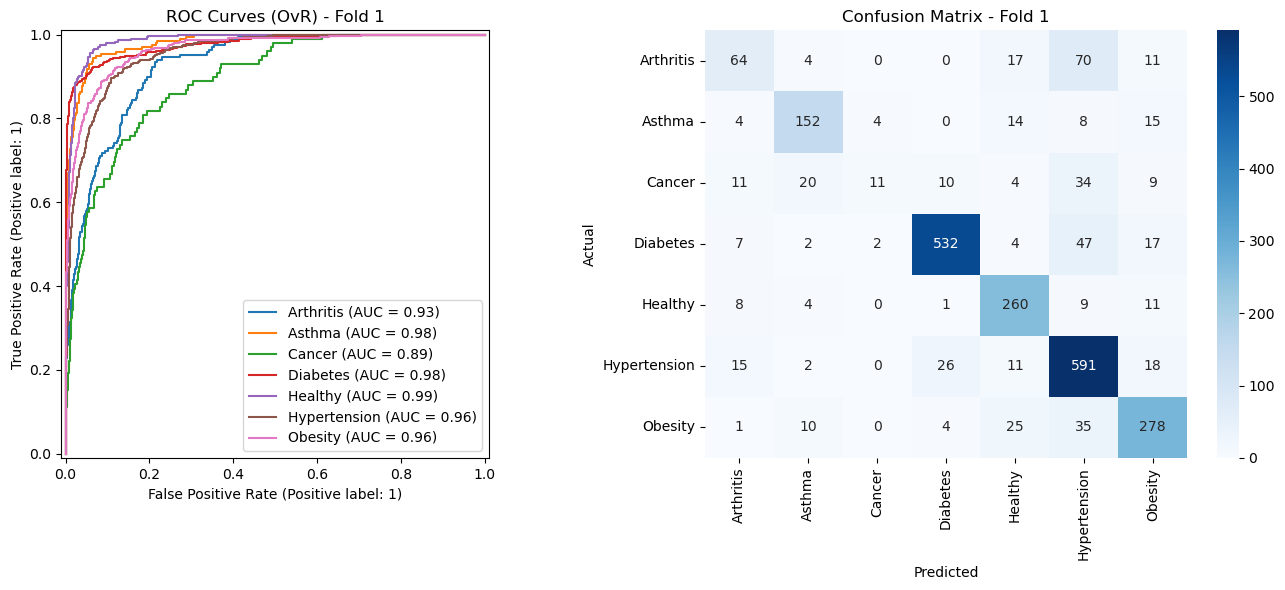


Classification Report for Fold 1:

Disease: Arthritis
TP: 64, FP: 46, TN: 2170, FN: 102
Accuracy: 0.9379, Precision: 0.5818, Recall: 0.3855, F1: 0.4638

Disease: Asthma
TP: 152, FP: 42, TN: 2143, FN: 45
Accuracy: 0.9635, Precision: 0.7835, Recall: 0.7716, F1: 0.7775

Disease: Cancer
TP: 11, FP: 6, TN: 2277, FN: 88
Accuracy: 0.9605, Precision: 0.6471, Recall: 0.1111, F1: 0.1897

Disease: Diabetes
TP: 532, FP: 41, TN: 1730, FN: 79
Accuracy: 0.9496, Precision: 0.9284, Recall: 0.8707, F1: 0.8986

Disease: Healthy
TP: 260, FP: 75, TN: 2014, FN: 33
Accuracy: 0.9547, Precision: 0.7761, Recall: 0.8874, F1: 0.8280

Disease: Hypertension
TP: 591, FP: 203, TN: 1516, FN: 72
Accuracy: 0.8846, Precision: 0.7443, Recall: 0.8914, F1: 0.8113

Disease: Obesity
TP: 278, FP: 81, TN: 1948, FN: 75
Accuracy: 0.9345, Precision: 0.7744, Recall: 0.7875, F1: 0.7809

Overal GBM model accuracy across all diseases: 0.7926

======= FOLD 2 =======

Class frequencies in TEST fold:
Medical Condition
Hypertension    66

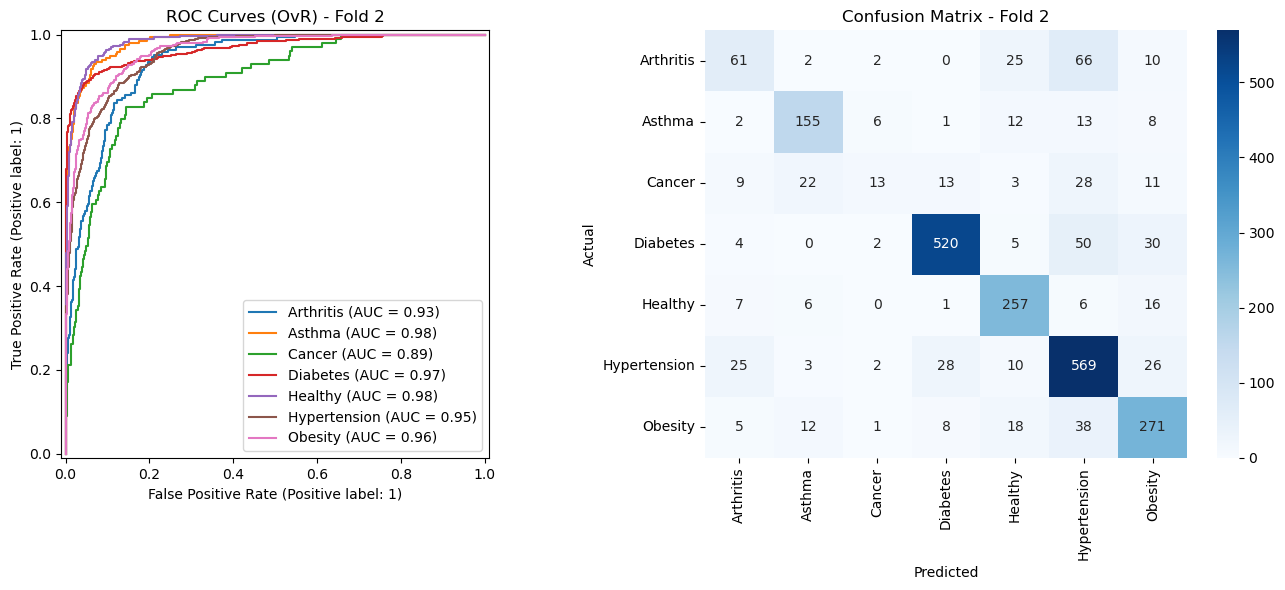


Classification Report for Fold 2:

Disease: Arthritis
TP: 61, FP: 52, TN: 2164, FN: 105
Accuracy: 0.9341, Precision: 0.5398, Recall: 0.3675, F1: 0.4373

Disease: Asthma
TP: 155, FP: 45, TN: 2140, FN: 42
Accuracy: 0.9635, Precision: 0.7750, Recall: 0.7868, F1: 0.7809

Disease: Cancer
TP: 13, FP: 13, TN: 2270, FN: 86
Accuracy: 0.9584, Precision: 0.5000, Recall: 0.1313, F1: 0.2080

Disease: Diabetes
TP: 520, FP: 51, TN: 1720, FN: 91
Accuracy: 0.9404, Precision: 0.9107, Recall: 0.8511, F1: 0.8799

Disease: Healthy
TP: 257, FP: 73, TN: 2016, FN: 36
Accuracy: 0.9542, Precision: 0.7788, Recall: 0.8771, F1: 0.8250

Disease: Hypertension
TP: 569, FP: 201, TN: 1518, FN: 94
Accuracy: 0.8762, Precision: 0.7390, Recall: 0.8582, F1: 0.7941

Disease: Obesity
TP: 271, FP: 101, TN: 1928, FN: 82
Accuracy: 0.9232, Precision: 0.7285, Recall: 0.7677, F1: 0.7476

Overal GBM model accuracy across all diseases: 0.7750

======= FOLD 3 =======

Class frequencies in TEST fold:
Medical Condition
Hypertension    

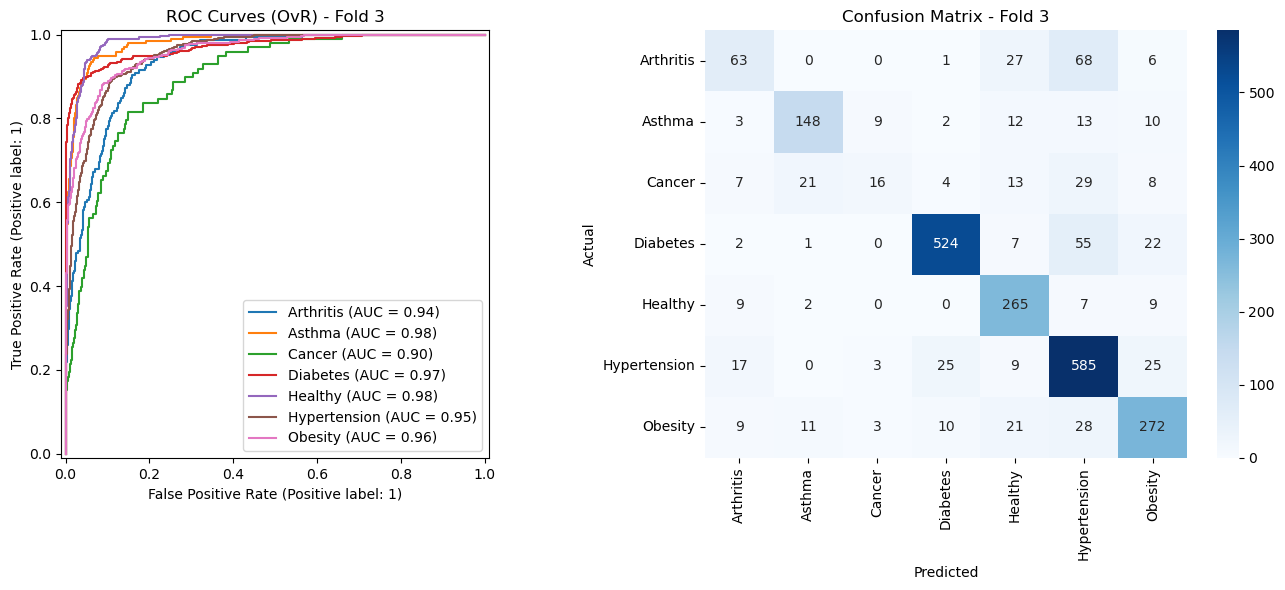


Classification Report for Fold 3:

Disease: Arthritis
TP: 63, FP: 47, TN: 2169, FN: 102
Accuracy: 0.9374, Precision: 0.5727, Recall: 0.3818, F1: 0.4582

Disease: Asthma
TP: 148, FP: 35, TN: 2149, FN: 49
Accuracy: 0.9647, Precision: 0.8087, Recall: 0.7513, F1: 0.7789

Disease: Cancer
TP: 16, FP: 15, TN: 2268, FN: 82
Accuracy: 0.9593, Precision: 0.5161, Recall: 0.1633, F1: 0.2481

Disease: Diabetes
TP: 524, FP: 42, TN: 1728, FN: 87
Accuracy: 0.9458, Precision: 0.9258, Recall: 0.8576, F1: 0.8904

Disease: Healthy
TP: 265, FP: 89, TN: 2000, FN: 27
Accuracy: 0.9513, Precision: 0.7486, Recall: 0.9075, F1: 0.8204

Disease: Hypertension
TP: 585, FP: 200, TN: 1517, FN: 79
Accuracy: 0.8828, Precision: 0.7452, Recall: 0.8810, F1: 0.8075

Disease: Obesity
TP: 272, FP: 80, TN: 1947, FN: 82
Accuracy: 0.9320, Precision: 0.7727, Recall: 0.7684, F1: 0.7705

Overal GBM model accuracy across all diseases: 0.7866

======= FOLD 4 =======

Class frequencies in TEST fold:
Medical Condition
Hypertension    6

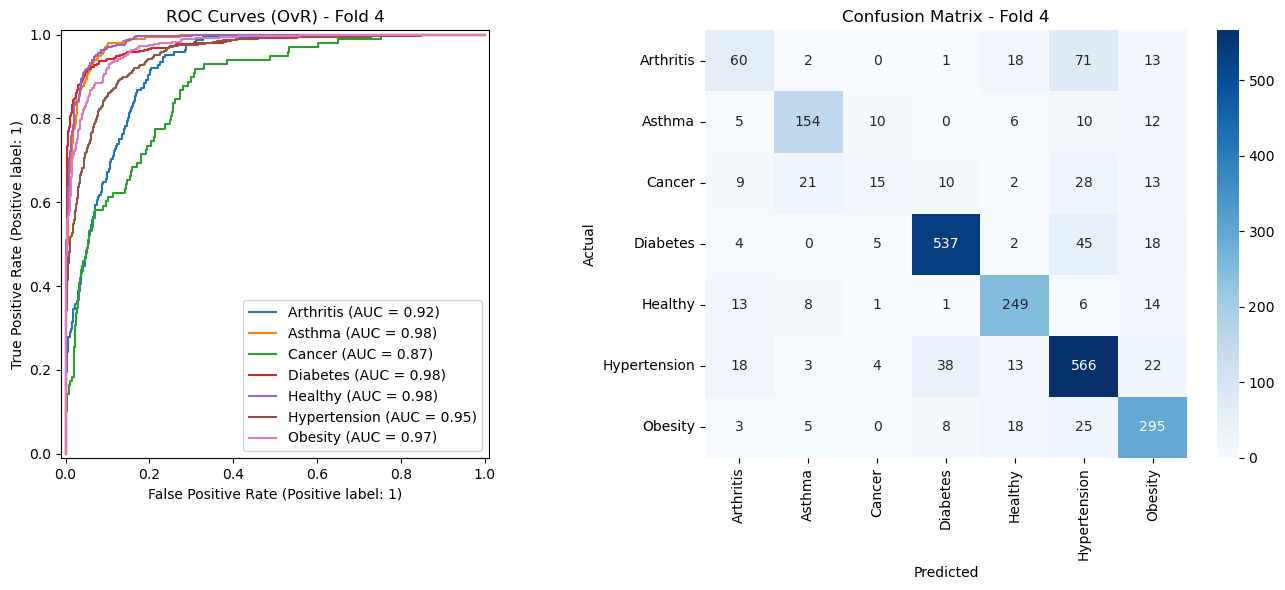


Classification Report for Fold 4:

Disease: Arthritis
TP: 60, FP: 52, TN: 2164, FN: 105
Accuracy: 0.9341, Precision: 0.5357, Recall: 0.3636, F1: 0.4332

Disease: Asthma
TP: 154, FP: 39, TN: 2145, FN: 43
Accuracy: 0.9656, Precision: 0.7979, Recall: 0.7817, F1: 0.7897

Disease: Cancer
TP: 15, FP: 20, TN: 2263, FN: 83
Accuracy: 0.9567, Precision: 0.4286, Recall: 0.1531, F1: 0.2256

Disease: Diabetes
TP: 537, FP: 58, TN: 1712, FN: 74
Accuracy: 0.9446, Precision: 0.9025, Recall: 0.8789, F1: 0.8905

Disease: Healthy
TP: 249, FP: 59, TN: 2030, FN: 43
Accuracy: 0.9572, Precision: 0.8084, Recall: 0.8527, F1: 0.8300

Disease: Hypertension
TP: 566, FP: 185, TN: 1532, FN: 98
Accuracy: 0.8811, Precision: 0.7537, Recall: 0.8524, F1: 0.8000

Disease: Obesity
TP: 295, FP: 92, TN: 1935, FN: 59
Accuracy: 0.9366, Precision: 0.7623, Recall: 0.8333, F1: 0.7962

Overal GBM model accuracy across all diseases: 0.7879

======= FOLD 5 =======

Class frequencies in TEST fold:
Medical Condition
Hypertension    6

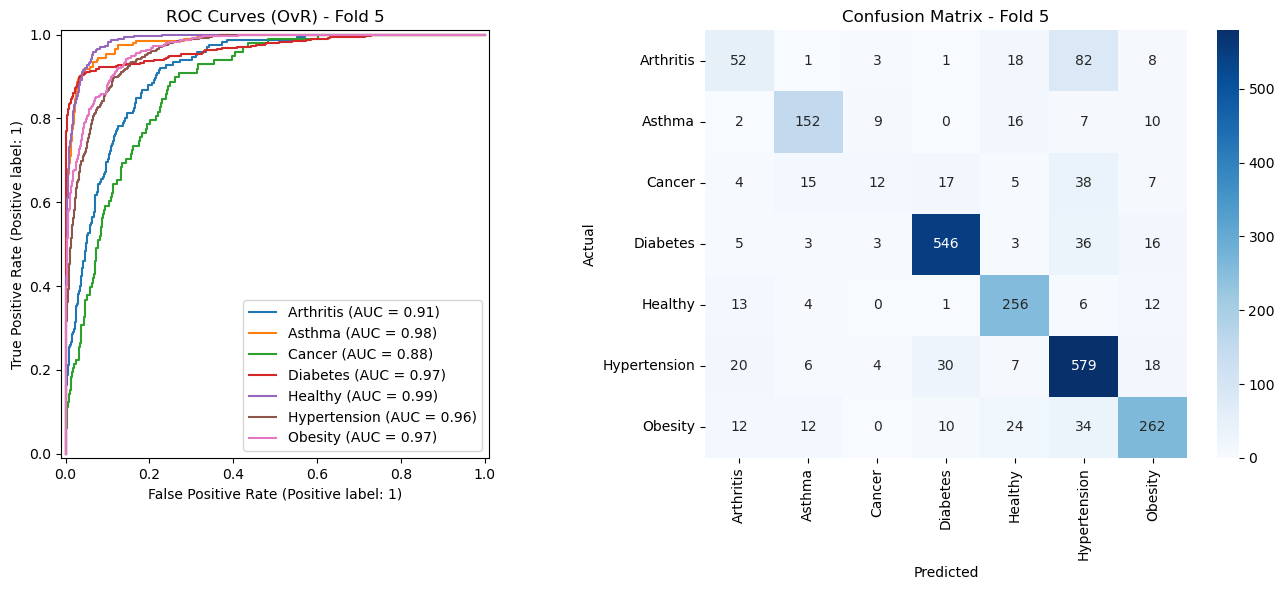


Classification Report for Fold 5:

Disease: Arthritis
TP: 52, FP: 56, TN: 2160, FN: 113
Accuracy: 0.9290, Precision: 0.4815, Recall: 0.3152, F1: 0.3810

Disease: Asthma
TP: 152, FP: 41, TN: 2144, FN: 44
Accuracy: 0.9643, Precision: 0.7876, Recall: 0.7755, F1: 0.7815

Disease: Cancer
TP: 12, FP: 19, TN: 2264, FN: 86
Accuracy: 0.9559, Precision: 0.3871, Recall: 0.1224, F1: 0.1860

Disease: Diabetes
TP: 546, FP: 59, TN: 1710, FN: 66
Accuracy: 0.9475, Precision: 0.9025, Recall: 0.8922, F1: 0.8973

Disease: Healthy
TP: 256, FP: 73, TN: 2016, FN: 36
Accuracy: 0.9542, Precision: 0.7781, Recall: 0.8767, F1: 0.8245

Disease: Hypertension
TP: 579, FP: 203, TN: 1514, FN: 85
Accuracy: 0.8790, Precision: 0.7404, Recall: 0.8720, F1: 0.8008

Disease: Obesity
TP: 262, FP: 71, TN: 1956, FN: 92
Accuracy: 0.9315, Precision: 0.7868, Recall: 0.7401, F1: 0.7627

Overal GBM model accuracy across all diseases: 0.7808


In [17]:
## Stratified K-Fold Cross-Validation Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X_selected, y), start=1):
    print(f"\n======= FOLD {fold} =======")

    # extract class labels for this test fold
    fold_y = y[test_idx]
    # compute and display class frequencies in this fold using disease names
    fold_counts = pd.Series(fold_y).map(idx_to_condition).value_counts()
    print("\nClass frequencies in TEST fold:")
    print(fold_counts)

    # training/validation splits (code is vectorized by speedy NumPy indexing)
    X_train, X_val = X_selected.values[train_idx], X_selected.values[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]

    ## Initialize and train GBM model with input hyperparameters
    model = GBMClassifier(
        n_estimators=HYPERPARAMS['n_estimators'],
        learning_rate=HYPERPARAMS['learning_rate'],
        max_depth=HYPERPARAMS['max_depth'],
        l2_reg=HYPERPARAMS['l2_reg'],
        early_stopping_rounds=HYPERPARAMS['early_stopping_rounds'],
        n_classes=len(idx_to_condition)
    )

    # fit model on training data with built-in validation for early stopping
    model.fit(X_train, y_train, X_val=X_val, y_val=y_val)

    # predict class labels and probabilities for validation set
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_prob(X_val)

    ## Plot ROC curves (OvR) and confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # plot OvR ROC curves for each disease
    for cls_idx, cls_name in idx_to_condition.items():
        RocCurveDisplay.from_predictions(
            (y_val == cls_idx).astype(int),
            y_pred_prob[:, cls_idx],
            ax=axes[0],
            name=cls_name
        )
    axes[0].set_title(f"ROC Curves (OvR) - Fold {fold}")
    axes[0].legend()

    # compute and plot confusion matrix heatmap
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d',
        ax=axes[1],
        cmap='Blues',
        xticklabels=list(idx_to_condition.values()),
        yticklabels=list(idx_to_condition.values())
    )
    axes[1].set_title(f"Confusion Matrix - Fold {fold}")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    ## Calculate and generate classification report (vectorized with NumPy)
    # Compute TP, FP, FN, TN from confusion matrix
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    # calculate performance validation metrics
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
    recall = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)
    f1 = np.divide(2 * precision * recall, precision + recall,
                   out=np.zeros_like(TP, dtype=float), where=(precision + recall) != 0)
    
    print(f"\nClassification Report for Fold {fold}:")

    # display metrics for each disease class
    for cls_idx, cls_name in idx_to_condition.items():
        print(f"\nDisease: {cls_name}")
        print(f"TP: {TP[cls_idx]}, FP: {FP[cls_idx]}, TN: {TN[cls_idx]}, FN: {FN[cls_idx]}")
        print(f"Accuracy: {accuracy[cls_idx]:.4f}, Precision: {precision[cls_idx]:.4f}, " +
              f"Recall: {recall[cls_idx]:.4f}, F1: {f1[cls_idx]:.4f}")

    # display overall accuracy
    overall_accuracy = TP.sum() / cm.sum()
    print(f"\nOveral GBM model accuracy across all diseases: {overall_accuracy:.4f}")

___
## **Interpretation of Results:**

### **ROC Curves:**

ROC curves plot the **True Positive Rate (TPR) vs. False Positive Rate (FPR)**, and the ROC Area Under Curve (**ROC AUC**) measures a model's ability to rank positive samples higher than negative ones regardless of a specific threshold. Hence, ROC curves are much more informative relative to performance metrics such as accuracy when dealing with **highly-skewed, multi-class data** (such as the medical dataset being studied). When examining all five folds, we observe that the ROC curves have a consistent strong performance for all the diseases, with "Asthma, "Diabetes", and "Healthy" patients having the highest AUC values between 0.97 and 0.99 in each fold. This means that the model can reliably differentiate these classes from the other medical conditions using the selected features. On the other hand, "Arthritis," "Hypertension", and "Obesity" produce slightly smaller AUCs between about 0.91 and 0.97, which still are quite strong. 

We find that "Cancer" exhibits the lowest AUCs with values centered at ~0.89. In addition to "Cancer" being the rarest disease in the dataset, it is also an umbrella of conditions that can be highly difficult to predict despite being given demographic information, metabolic markers, and lifestyle scores. The lower accuracy of the model with regards to classifying "Cancer" can be attributed to its real-world complexity that defies being defined by a few parameters. The consistency of the ROC curves across folds also demonstrates the **effectiveness of stratified k-folding** in preserving similar output classifications across folds without overfitting. Evaluating the model in its entirety, we observe a **moderately strong 78.08% accuracy** using only 100 estimators. 

### **Confusion Matrices:**

Confusion matrices visualize how well a model performs by displaying its **predictions against true labels**. We observe that "Diabetes" and "Hypertension" have relatively high true positive counts and few false positives, which is expected from their strong correlation to metabolic parameters. Next, "Asthma," "Healthy" and "Obesity" also have moderately high true positive rates, but individuals with "Arthritis" are often misclassified as having "Hypertension" with <30% true positive rates for "Arthritis". It is no surprise that cancer has the lowest true positive rate amongst all of the diseases and is routinely misclassified.

___
## **Conclusion:**

Overall, this implementation of a multi-class **GBM classifier** demonstrates the moderate effectiveness of a small set of physiological parameters (Age, Glucose, Blood Pressure, BMI, Oxygen Saturation, and Sleep Hours) in diagnostically predicting patient medical conditions. Despite challenges posed by class imbalance with low-frequency conditions like "Cancer" and "Asthma", the use of **stratified k-fold cross-validation** ensured reliable model training and evaluation across folds. Furthermore, the model achieved a **moderately strong accuracy of 78.45%** with ROC AUC scores for all diseases except "Cancer" being routinely above 0.90. The ROC curves and confusion matrices highlight that the model performs best on diseases like "Diabetes" and "Hypertension" that are highly-correlated with metabolic metrics. Overall, this project demonstrates the effectiveness of **OvR gradient boosting** for multi-class medical classification tasks and provides insight into which risk factors most strongly contribute to chronic disease prediction. Though this project may inspire lifestyle choices to protect one's health, it is not suited to reliably predict patient disease in a hospital setting.